In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
from scipy import signal

In [5]:
###radiometer equation
def radiofunc(sigma,tsys,tsky,G,B,tobs):
    return (sigma*(tsys+tsky))/(G*np.sqrt(2*B*tobs))

def sefd_rms(sigma,sefd,tobs,b):
    return (sefd/np.sqrt(tobs*b)*sigma)

tsky=7 ###kelvin
###askap
craft_sefd=2000
craft_b=336e6
tobs=5e-3
print("CRAFT")
print(sefd_rms(10,craft_sefd,tobs,craft_b))
print(sefd_rms(10,craft_sefd,tobs*55861,craft_b))
###utmost
utmost_sefd=120
utm_b=31.25e6
tobs=5e-3
print("utmost")
print(sefd_rms(10,utmost_sefd,tobs,utm_b))

###parkes telescope param
pks_tsys=21
pks_g=1.36
pks_sefd=29
pks_b=350e6 ###Hz
tobs=1e-3 ###width or integration time ##seconds
print("Parkes Radio Telescope")
pks_sens=radiofunc(10,pks_tsys,tsky,pks_g,pks_b,tobs)
print(pks_sens,"Jy")
print(sefd_rms(10,pks_sefd,tobs,pks_b))
#####GBT
gbt_tsys=20
gbt_g=2.0
gbt_b=650e6
print("Green Bank Telescope")
gbt_sens=radiofunc(10,gbt_tsys,tsky,gbt_g,gbt_b,tobs)
print(gbt_sens,"Jy")


#####Arecibo
alfa_tsys=30
alfa_g=10
alfa_b=100e6
print("Arecibo L-band Feed Array")
alfa_sens=radiofunc(10,alfa_tsys,tsky,alfa_g,alfa_b,tobs)
print(alfa_sens,"Jy")


CRAFT
15.430334996209192
0.06528614147578675
utmost
3.035786553761644
Parkes Radio Telescope
0.24607647839237515 Jy
0.4901894677425396
Green Bank Telescope
0.11840283260644895 Jy
Arecibo L-band Feed Array
0.08273451516749221 Jy


In [3]:
###survey times in seconds

pmbs_time=2100
htru_time=4300
askap_t=10*3600 ##hrs
superb_t=560

utmost=9
#### craft-gp has 63.117 antenna_days
gp_total=63.117*24 ###hours
####parkes and ASKAP FOV
askap=22.9022104447
parkes=0.5558873668
palfa=0.01713858784 ##3.35 arcmin (3.35/2/60)^2*7*pi
gbt=0.03692682 ##13 arcmin (3.35/2/60)^2*7*pi
print("gbt fov is %.5f"%((13.01/2/60)**2*np.pi))
print("planned CRAFT-GP total FOV is %f deg $^2$"%(askap*160))
print("real CRAFT-GP total coverage is %f deg $^2$ hrs"%(askap*63.117*24))
#####this needs to be fixed

pmbs_start=2100/3600#*0.5558873668
pmbs_x=np.array([1e2,pmbs_start,1e-5])
pmbs_y=pmbs_x*0+pks_sens

htru_start=4300/3600#*0.5558873668
htru_x=np.array([1e2,htru_start,1e-5])
htru_y=htru_x*0+pks_sens

utmost10=10#*utmost
utmost_sens=3
utmost_start=10#*22.9022104447
utmost_x=np.array([1e2,utmost_start,1e-5])
utmost_y=utmost_x*0+3

askap_start=10#*22.9022104447
askap_x=np.array([1e2,askap_start,1e-5])
askap_y=askap_x*0+2*10


gbt_start=10#*gbt
gbt_x=np.array([1e2,gbt_start,1e-5])
gbt_y=gbt_x*0+gbt_sens

alfa_start=10#*gbt
alfa_x=np.array([1e2,alfa_start,1e-5])
alfa_y=alfa_x*0+alfa_sens

superb_s=560/3600#*0.5558873668
superb_x=np.array([1e2,superb_s,1e-5])
superb_y=superb_x*0+pks_sens



gbt fov is 0.03693
planned CRAFT-GP total FOV is 3664.353671 deg $^2$
real CRAFT-GP total coverage is 34692.451599 deg $^2$ hrs


In [4]:
##### log normal pulse stack distribution

def log_normal(sigma,mu,x):
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * (sigma**2)))/ (x * sigma * np.sqrt(2 * np.pi)))
    ##e^(-(log(x) - μ)^2/(2 σ^2))/(sqrt(2 π) σ x)
    return pdf

def gauss_normal(x):
    pdf=np.exp(-(x)**2/(2 * 1**2))/ (1 * np.sqrt(2 * np.pi))
    return pdf
print(log_normal(0.1,1.0,1))

7.694598626706474e-22


<IPython.core.display.Javascript object>


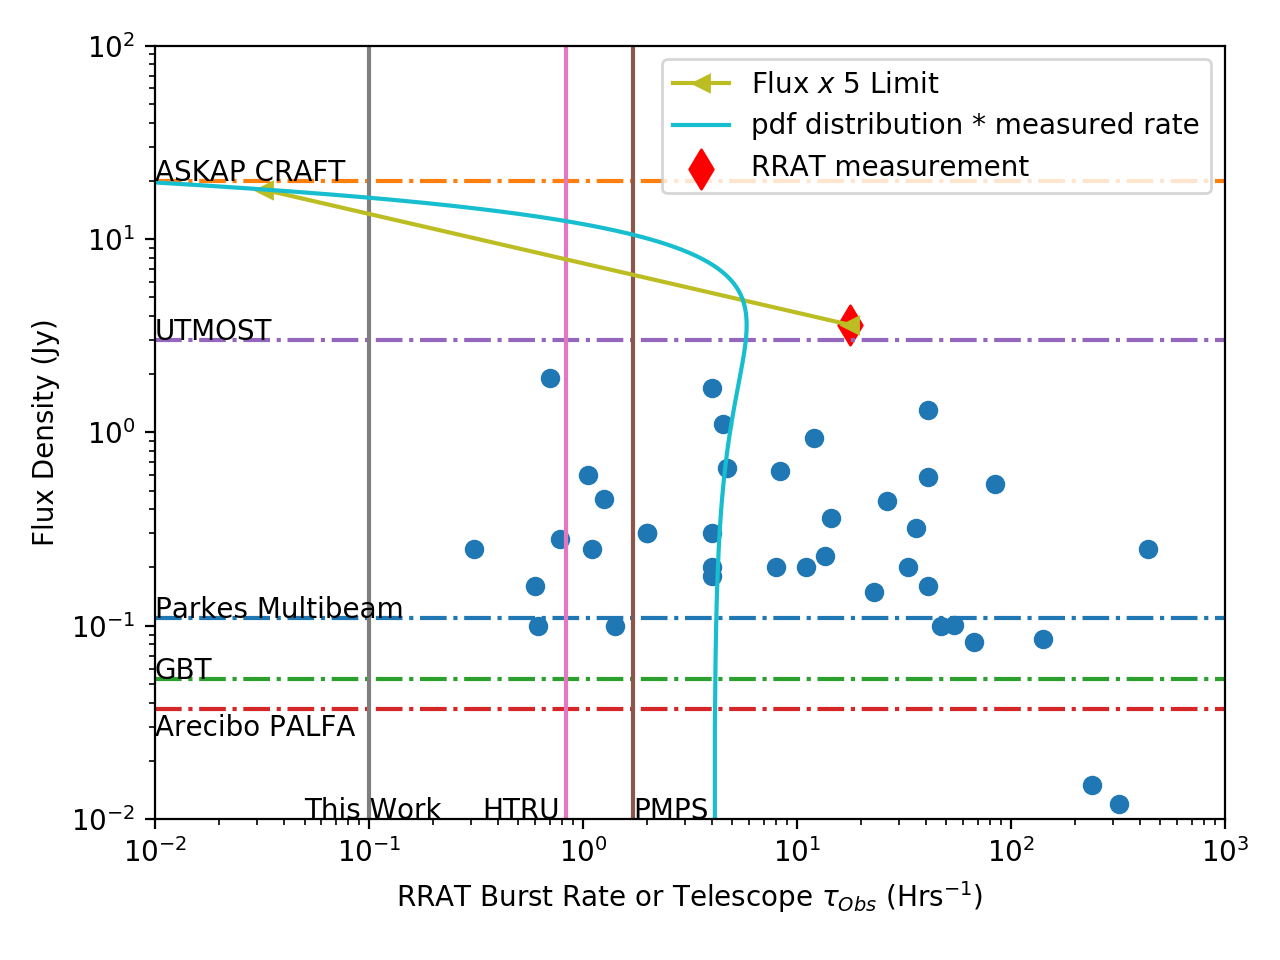

17.62 3.6
0.33062270402231747
40


In [5]:
plt.figure(0)

b_rate=np.loadtxt('../cat/b_rates')
b_wd=np.loadtxt('../cat/b_wd')
b_flux=np.loadtxt('../cat/b_rates_flux')

oc=b_rate#/3600
flux=b_flux/1000

max=np.where(flux==flux.max())[0][0]
###oc[max],flux[max]
###normalized energy value is
lgn_e=flux[max]
print(oc[max],lgn_e)

lgn_sig=0.15
lgn_mu=1.5

distr=np.arange(0.01,10,0.01)
#fluxx3=log_normal(lgn_sig,lgn_mu,5)
fdistr=log_normal(lgn_sig,lgn_mu,distr)
distr=np.arange(0.01,10,0.01)
distr2=np.arange(-3,3,0.01)

#fluxx3=log_normal(lgn_sig,lgn_mu,3)
fdistr=log_normal(lgn_sig,lgn_mu,distr)
g_noise=gauss_normal(distr2)


max=np.where(flux==flux.max())[0][0]



res=signal.convolve(fdistr, g_noise, mode='same') / sum(fdistr)
#print (distr2)
apos=np.where(res==res.max())
x_res=np.linspace(0,10,len(res))
dpos=x_res[apos]-1
x_res=x_res-dpos
#print(np.intersect1d(np.where(x_res>5),np.where(x_res<5.01)))
sig5pos=np.intersect1d(np.where(x_res>5),np.where(x_res<5.01))[0]
print(res.max())
#print(sum(fdistr*distr))
#print(fluxx3,fluxx3*oc[max])


plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux Density (Jy)')
plt.xlabel("RRAT Burst Rate or Telescope $\\tau_{Obs}$ (Hrs$^{-1}$)")
#plt.xlabel("Spatial Coverage Time (deg$^{-1}$ s$^{-1}$)")



#plt.fill_between(1/pmbs_x,pmbs_y,100,alpha=0.5,label='PMPS')
#plt.fill_between(1/htru_x,htru_y,100,alpha=0.5,label='HTRU')
#plt.fill_between(1/superb_x,superb_y,100,alpha=0.5,label='SUPERB')
#plt.fill_between(1/askap_x,askap_y,100,alpha=0.5,label='CRAFT-GP')

#plt.scatter(1/pmbs_x[1],pmbs_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='PMPS')

plt.plot(1/pmbs_x,pmbs_y,"-.")
plt.plot(1/askap_x,askap_y,"-.")
plt.plot(1/gbt_x,gbt_y,"-.")
plt.plot(1/alfa_x,alfa_y,"-.")
plt.plot(1/utmost_x,utmost_y,"-.")
#### vertical lines
plt.plot([1/pmbs_time*3600,1/pmbs_time*3600],[1e-2,1e2],"-")
plt.plot([1/htru_time*3600,1/htru_time*3600],[1e-2,1e2],"-")
plt.plot([1/askap_t*3600,1/askap_t*3600],[1e-2,1e2],"-")


#plt.scatter(1/htru_x[1],htru_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='HTRU')
#plt.scatter(1/superb_x[1],superb_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='SUPERB')
#plt.scatter(1/askap_x[1],askap_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='CRAFT-GP')

plt.scatter(oc,flux)


#plt.annotate('PMPS',(1/pmbs_x[0],pmbs_y[0]))
#plt.annotate('HTRU',(1/htru_x[0],htru_y[0]))
plt.annotate('ASKAP CRAFT',(1/askap_x[0],askap_y[0]))
#plt.annotate('SUPERB',(1/superb_x[0],superb_y[0]))
plt.annotate('Parkes Multibeam',(1/pmbs_x[0],pmbs_y[0]))

#plt.scatter(1/gbt_x[0],gbt_y[0],marker=r'$\llcorner$',s=700,alpha=0.5,label='GBT 10Hr')

plt.annotate('GBT',(1/gbt_x[0],gbt_y[0]))
plt.annotate('Arecibo PALFA',(1/alfa_x[0],(alfa_y[0]-0.01)))
plt.annotate('UTMOST',(1/utmost_x[0],(utmost_y[0]-0.01)))
plt.annotate("PMPS",(1/pmbs_time*3600,1e-2))
plt.annotate("HTRU",(1/htru_time*3600-0.5,1e-2))
plt.annotate("This Work",(1/askap_t*3600-0.05,1e-2))

plt.plot([oc[max],res[sig5pos]*oc[max]],[lgn_e,lgn_e*5],"-<",label="Flux $x$ 5 Limit")
plt.scatter(oc[max],flux[max],s=100,marker="d",c='red',label='RRAT measurement')
#plt.plot(oc[max]*fdistr,flux[max]*distr)
plt.plot(oc[max]*res,flux[max]*x_res,label="pdf distribution * measured rate")
plt.xlim(1e-2,1e3)
plt.ylim(1e-2,1e2)
#plt.grid(True)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig("rrat_space.pdf")
plt.show()
#print(pmbs_y)
print(len(oc))

<IPython.core.display.Javascript object>


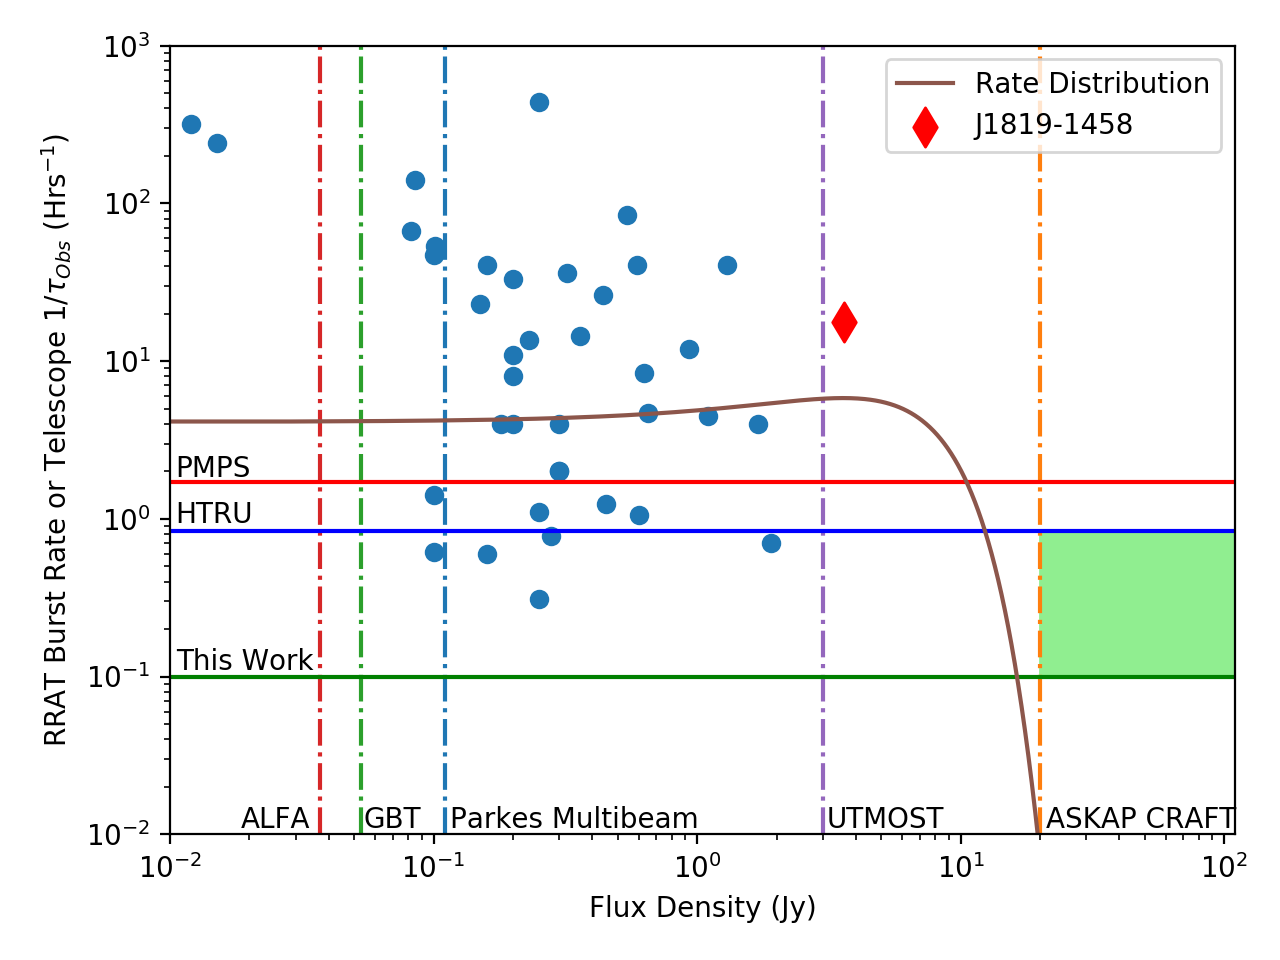

17.62 3.6
0.33062270402231747


In [6]:
####inverse plot
plt.figure(22)

b_rate=np.loadtxt('../cat/b_rates')
b_wd=np.loadtxt('../cat/b_wd')
b_flux=np.loadtxt('../cat/b_rates_flux')

oc=b_rate#/3600
flux=b_flux/1000

max=np.where(flux==flux.max())[0][0]
###oc[max],flux[max]
###normalized energy value is
lgn_e=flux[max]
print(oc[max],lgn_e)

lgn_sig=0.15
lgn_mu=1.5

distr=np.arange(0.01,10,0.01)
#fluxx3=log_normal(lgn_sig,lgn_mu,5)
fdistr=log_normal(lgn_sig,lgn_mu,distr)
distr=np.arange(0.01,10,0.01)
distr2=np.arange(-3,3,0.01)

#fluxx3=log_normal(lgn_sig,lgn_mu,3)
fdistr=log_normal(lgn_sig,lgn_mu,distr)
g_noise=gauss_normal(distr2)


max=np.where(flux==flux.max())[0][0]



res=signal.convolve(fdistr, g_noise, mode='same') / sum(fdistr)
#print (distr2)
apos=np.where(res==res.max())
x_res=np.linspace(0,10,len(res))
dpos=x_res[apos]-1
x_res=x_res-dpos
#print(np.intersect1d(np.where(x_res>5),np.where(x_res<5.01)))
sig5pos=np.intersect1d(np.where(x_res>5),np.where(x_res<5.01))[0]
print(res.max())
#print(sum(fdistr*distr))
#print(fluxx3,fluxx3*oc[max])


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux Density (Jy)')
plt.ylabel("RRAT Burst Rate or Telescope $1/\\tau_{Obs}$ (Hrs$^{-1}$)")
#plt.xlabel("Spatial Coverage Time (deg$^{-1}$ s$^{-1}$)")
#plt.fill_between(x=[1e-2,1e3],y1=1/askap_t*3600,y2=1/htru_time*3600,color='skyblue')
plt.fill_between(x=[askap_y[0],1e3],y1=1/askap_t*3600,y2=1/htru_time*3600,color="lightgreen")


#plt.fill_between(1/pmbs_x,pmbs_y,100,alpha=0.5,label='PMPS')
#plt.fill_between(1/htru_x,htru_y,100,alpha=0.5,label='HTRU')
#plt.fill_between(1/superb_x,superb_y,100,alpha=0.5,label='SUPERB')
#plt.fill_between(1/askap_x,askap_y,100,alpha=0.5,label='CRAFT-GP')

#plt.scatter(1/pmbs_x[1],pmbs_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='PMPS')

plt.plot(pmbs_y,1/pmbs_x,"-.")
plt.plot(askap_y,1/askap_x,"-.")
plt.plot(gbt_y,1/gbt_x,"-.")
plt.plot(alfa_y,1/alfa_x,"-.")
plt.plot(utmost_y,1/utmost_x,"-.")
#### vertical lines
plt.plot([1e-2,1e2+1e1],[1/pmbs_time*3600,1/pmbs_time*3600],"-",color='red')
plt.plot([1e-2,1e2+1e1],[1/htru_time*3600,1/htru_time*3600],"-",color='blue')
plt.plot([1e-2,1e2+1e1],[1/askap_t*3600,1/askap_t*3600],"-",color='green')


#plt.scatter(1/htru_x[1],htru_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='HTRU')
#plt.scatter(1/superb_x[1],superb_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='SUPERB')
#plt.scatter(1/askap_x[1],askap_y[1],marker=r'$\llcorner$',s=700,alpha=0.5,label='CRAFT-GP')

plt.scatter(flux,oc)


#plt.annotate('PMPS',(1/pmbs_x[0],pmbs_y[0]))
#plt.annotate('HTRU',(1/htru_x[0],htru_y[0]))
plt.annotate('ASKAP CRAFT',(askap_y[0]+1,1/askap_x[0]+1e-3))
#plt.annotate('SUPERB',(1/superb_x[0],superb_y[0]))
plt.annotate('Parkes Multibeam',(pmbs_y[0]+0.5e-2,1/pmbs_x[0]+1e-3))

#plt.scatter(1/gbt_x[0],gbt_y[0],marker=r'$\llcorner$',s=700,alpha=0.5,label='GBT 10Hr')

plt.annotate('GBT',(gbt_y[0]+1e-3,1/gbt_x[0]+1e-3))
plt.annotate('ALFA',((alfa_y[0])-1.85e-2,1/alfa_x[0]+1e-3))
#plt.annotate('Arecibo',((alfa_y[0])-2.3e-2,1/alfa_x[0]+5.5e-3))
plt.annotate('UTMOST',((utmost_y[0])+1e-1,1/utmost_x[0]+1e-3))


###survey annotes
plt.annotate("PMPS",(1e-2+5e-4,1/pmbs_time*3600+0.12))
plt.annotate("HTRU",(1e-2+5e-4,1/htru_time*3600+0.1))
plt.annotate("This Work",(1e-2+5e-4,1/askap_t*3600+0.01))


###plot pdf
#plt.plot([lgn_e,lgn_e*5],[oc[max],res[sig5pos]*oc[max]],"-<",label="Flux $x$ 5 Limit")
plt.scatter(flux[max],oc[max],s=100,marker="d",c='red',label='J1819-1458')
#plt.plot(oc[max]*fdistr,flux[max]*distr)
plt.plot(flux[max]*x_res,oc[max]*res,label="Rate Distribution")##/res.max()
plt.ylim(1e-2,1e3)
plt.xlim(1e-2,1e2+1e1)
#plt.grid(True)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig("rrat_space.pdf")
plt.show()
#print(pmbs_y)

<IPython.core.display.Javascript object>


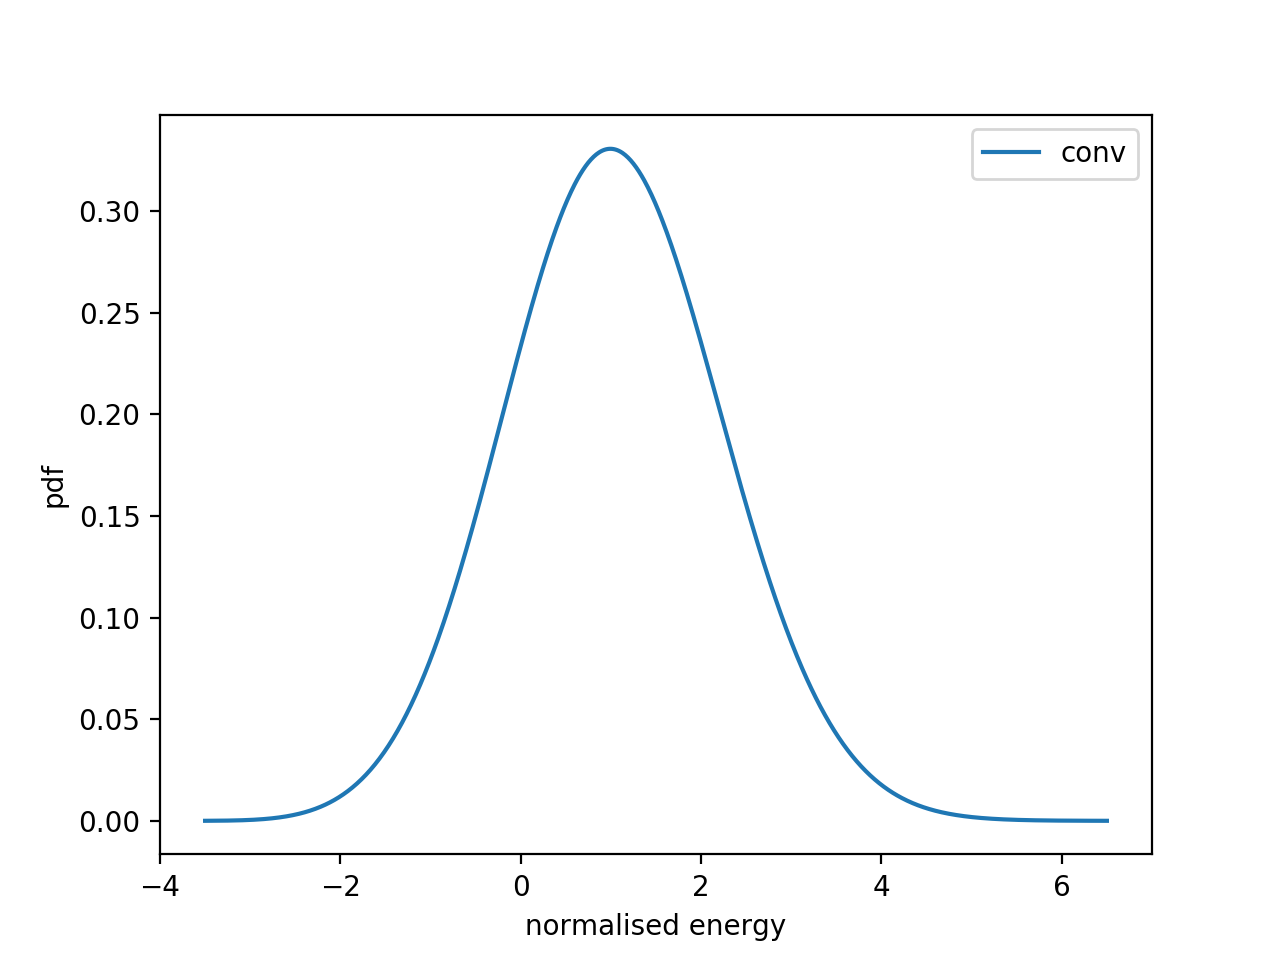

In [7]:
#max=np.where(flux==flux.max())[0][0]
###oc[max],flux[max]
###normalized energy

#lgn_e=flux[max]


lgn_sig=0.15
lgn_mu=1.5

distr=np.arange(0.01,10,0.01)
distr2=np.arange(-3,3,0.01)

#fluxx3=log_normal(lgn_sig,lgn_mu,3)
fdistr=log_normal(lgn_sig,lgn_mu,distr)
g_noise=gauss_normal(distr2)


max=np.where(flux==flux.max())[0][0]



res=signal.convolve(fdistr, g_noise, mode='same') / sum(fdistr)
#print (distr2)
apos=np.where(res==res.max())
x_res=np.linspace(0,10,len(res))
dpos=x_res[apos]-1
x_res=x_res-dpos
#print (x_res)
#np.random.lognormal(mu, sigma, 1000)
#print(g_noise.sum())
plt.figure(10)
#plt.xscale("log")
plt.xlabel("normalised energy")
plt.ylabel("pdf")
#plt.plot(distr,fdistr,label="log")
#plt.plot(distr2,g_noise,label='gaus')
plt.plot(x_res,res,label='conv')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


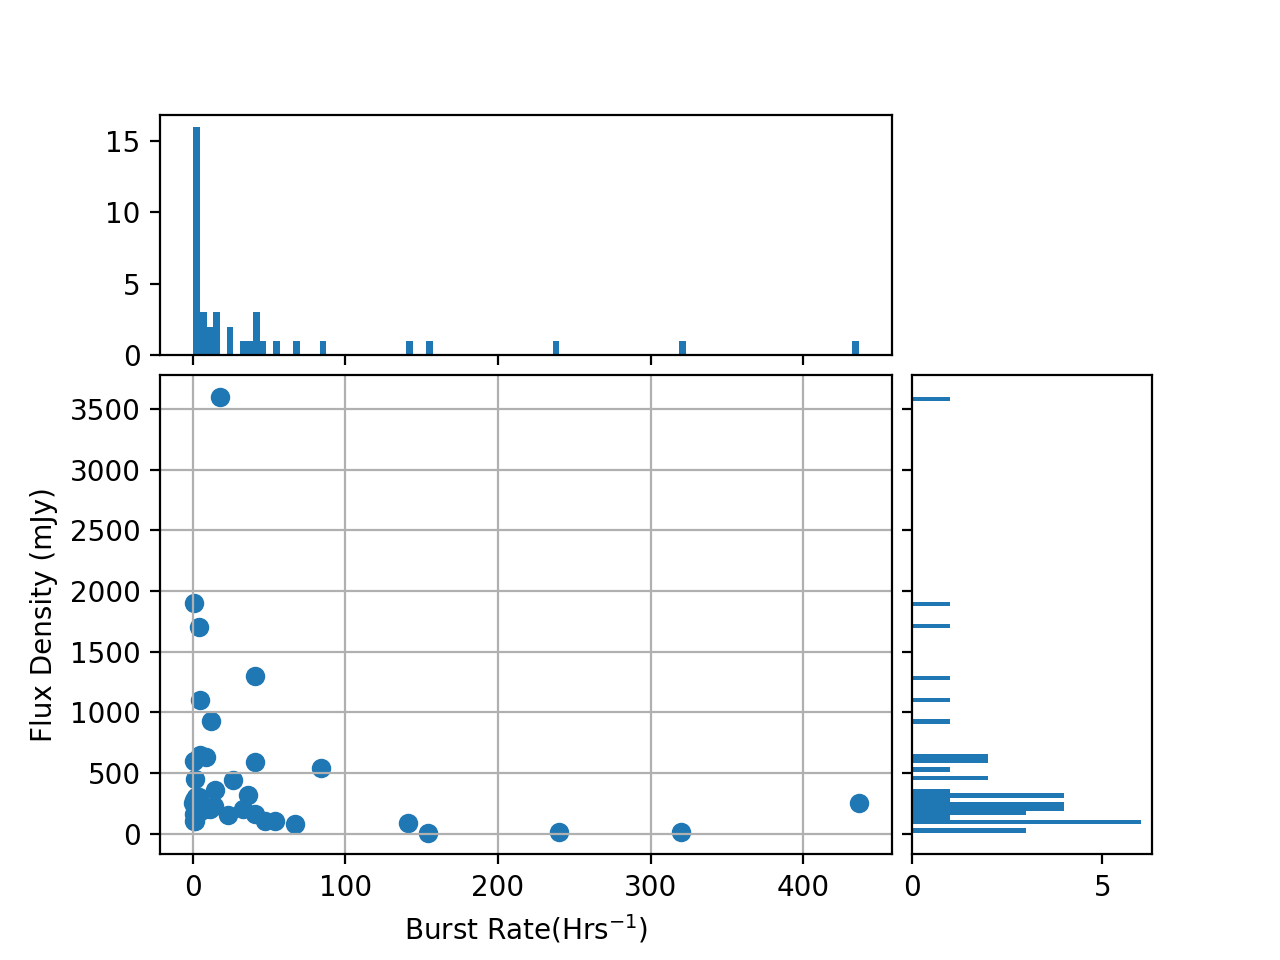

In [8]:

fig = plt.figure(1)

from mpl_toolkits.axes_grid1 import make_axes_locatable
x=oc
y=b_flux

# the scatter plot:
axScatter = plt.subplot(111)
axScatter.scatter(x, y)
plt.xlabel("Burst Rate(Hrs$^{-1}$)")
plt.ylabel("Flux Density (mJy)")
plt.grid(True)

#axScatter.set_aspect(1.)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

# make some labels invisible
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
         visible=False)

# now determine nice limits by hand:
#binwidth = 0.25
#xymax = np.max( [np.max(np.fabs(x)), np.max(np.fabs(y))] )
#lim = ( int(xymax/binwidth) + 1) * binwidth

#bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=100)
axHisty.hist(y, bins=100, orientation='horizontal')

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
#for tl in axHistx.get_xticklabels():
    #tl.set_visible(False)
#axHistx.set_yticks([0, 50,100])

#axHisty.axis["left"].major_ticklabels.set_visible(False)
#for tl in axHisty.get_yticklabels():
    #tl.set_visible(False)
#axHisty.set_xticks([0, 50, 100])


plt.draw()
plt.show()

<IPython.core.display.Javascript object>


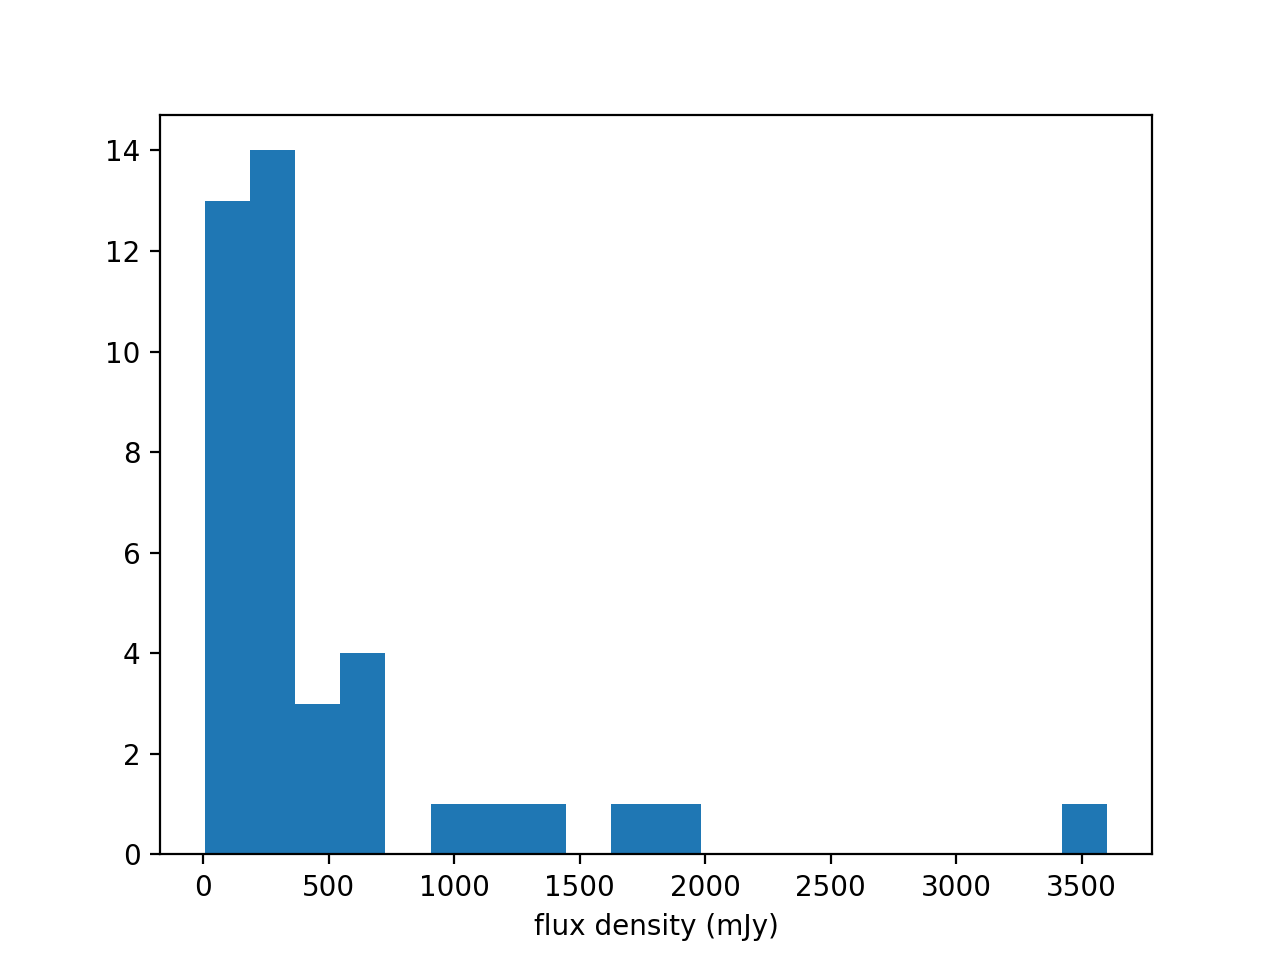

In [9]:
#### flux distribution of RRATs
plt.figure(2)
plt.hist(b_flux,bins=20)
plt.xlabel("flux density (mJy)")
plt.show()

<IPython.core.display.Javascript object>


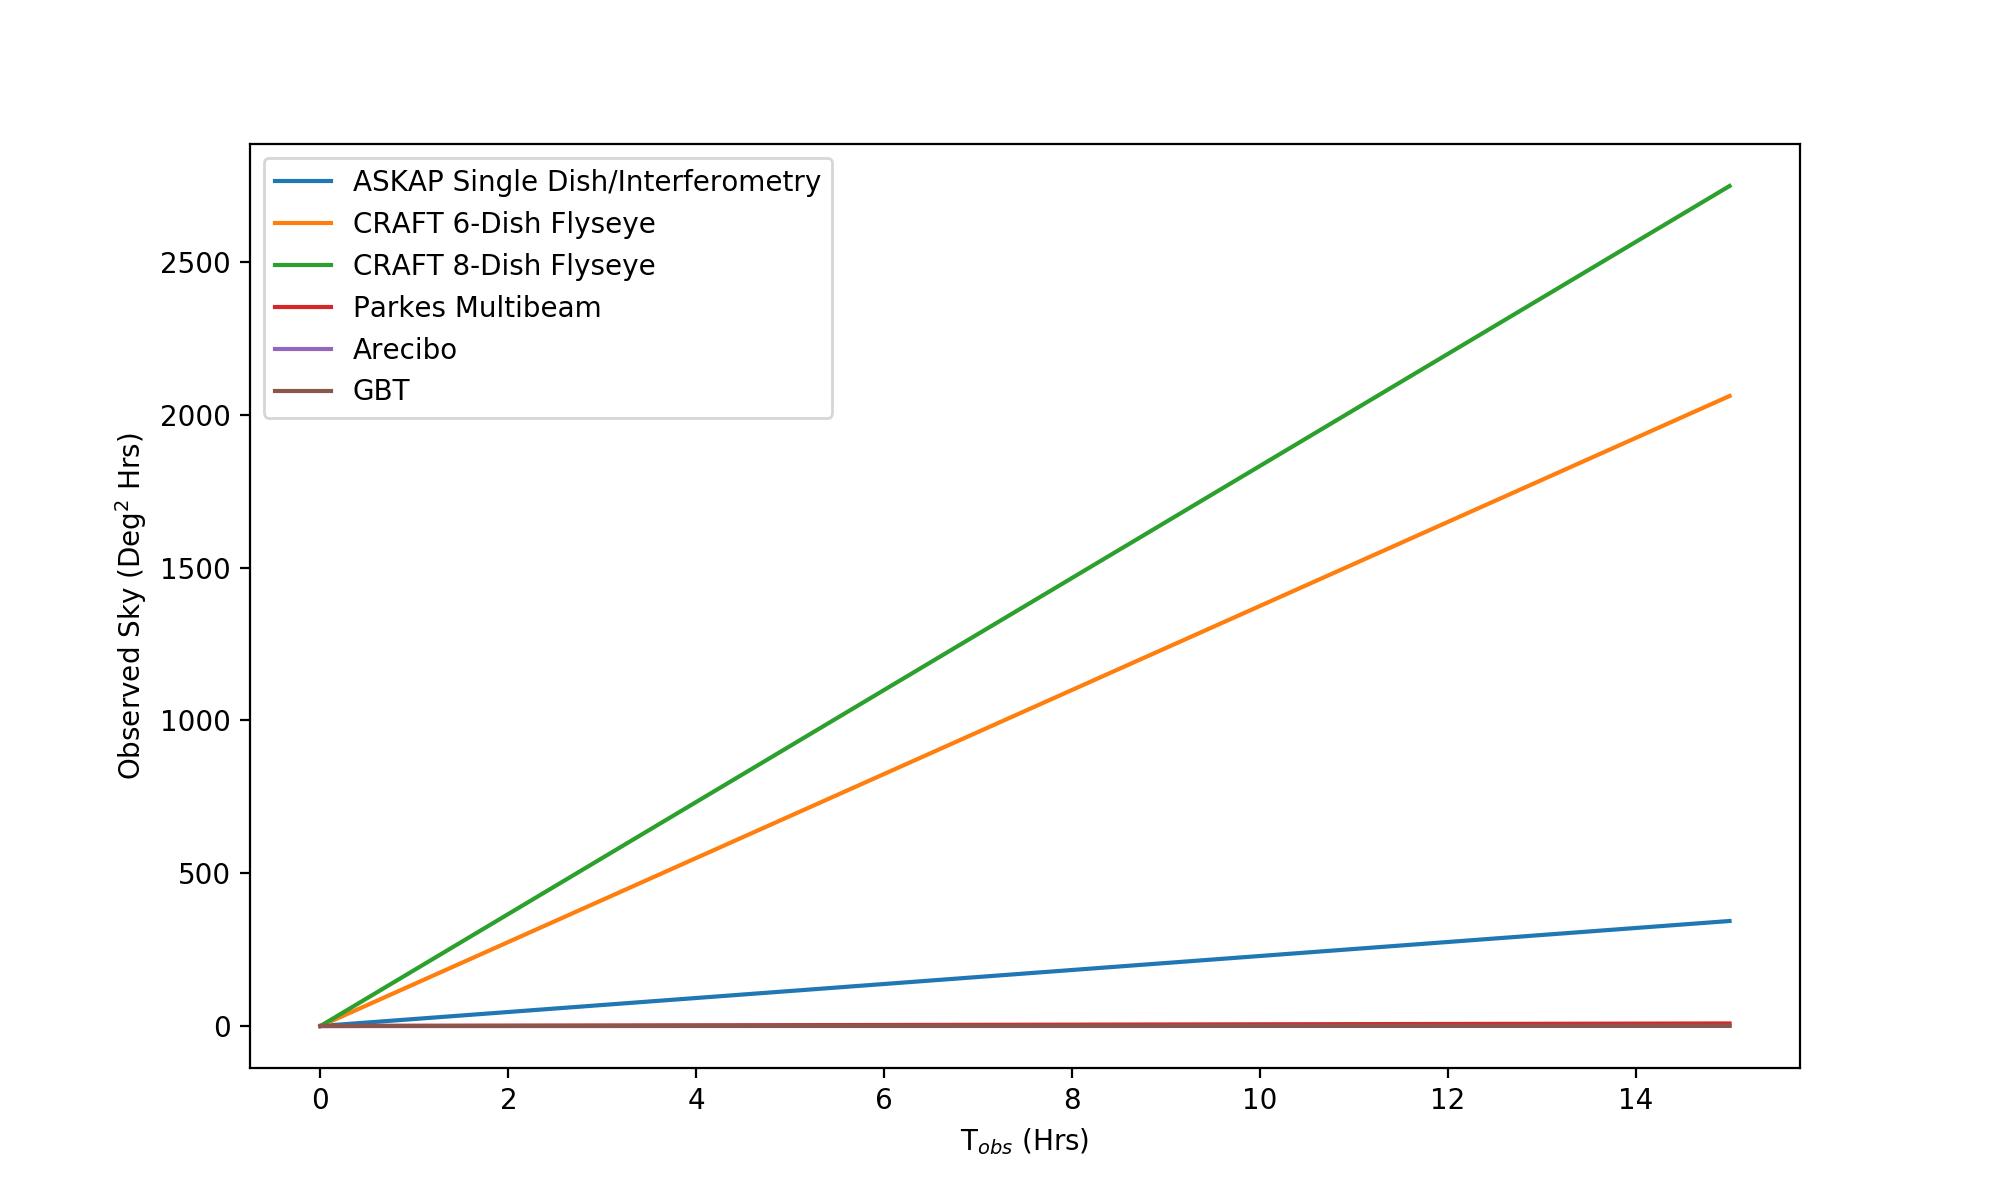

In [10]:
#####efficiency plot
plt.figure(3,figsize=(10,6))
timeline=np.array([0,15])
plt.xlabel("T$_{\t{obs}}$ (Hrs)")
plt.ylabel("Observed Sky (Deg$^2$ Hrs)")

plt.plot(timeline,timeline*askap,label='ASKAP Single Dish/Interferometry')
plt.plot(timeline,timeline*askap*6,label='CRAFT 6-Dish Flyseye')
plt.plot(timeline,timeline*askap*8,label='CRAFT 8-Dish Flyseye')
plt.plot(timeline,timeline*parkes,label='Parkes Multibeam')
plt.plot(timeline,timeline*palfa,label='Arecibo')
plt.plot(timeline,timeline*gbt,label='GBT')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


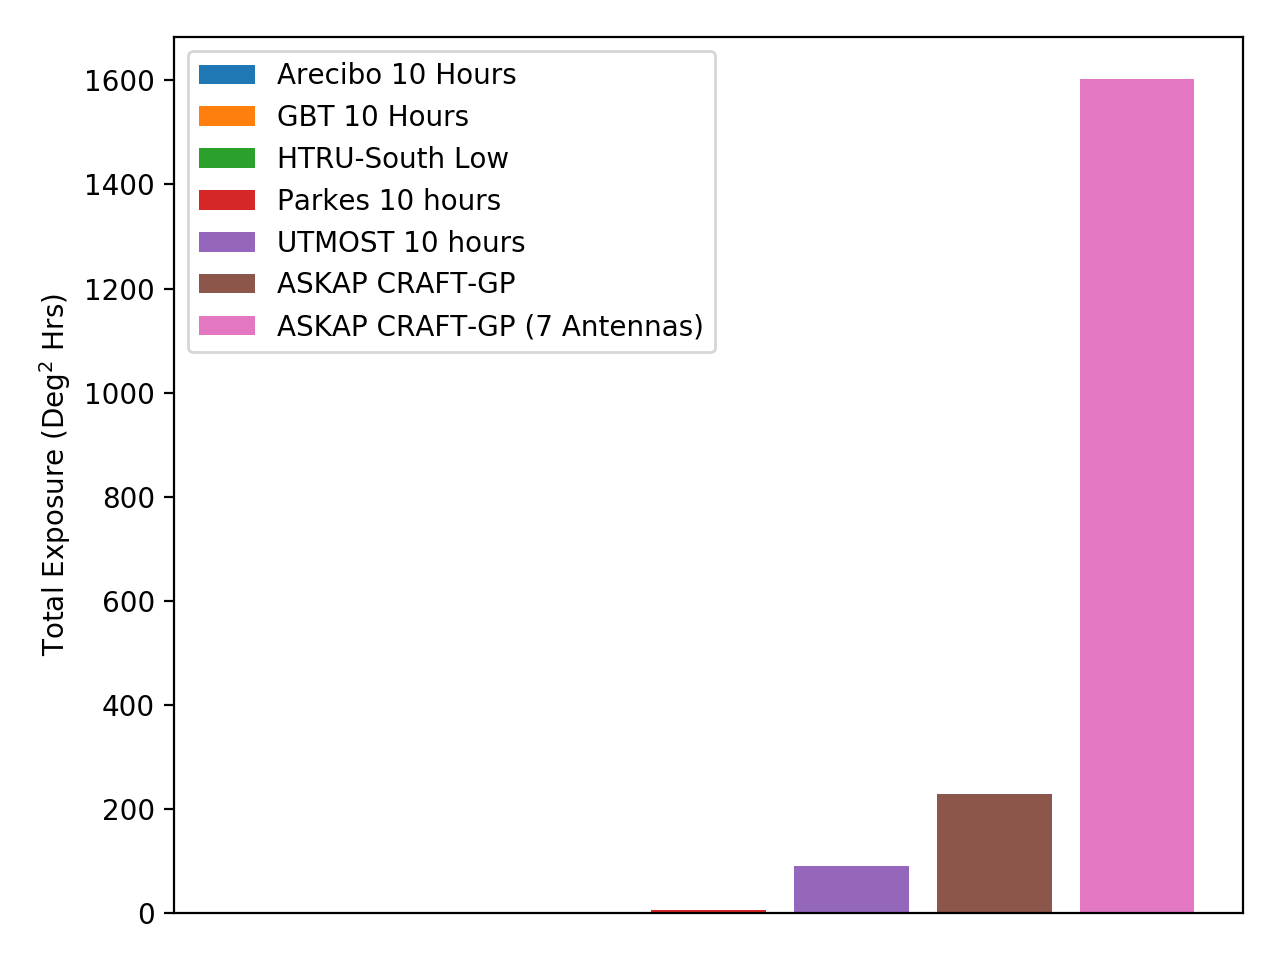

0.17138587840000002


In [11]:
plt.figure(4)
plt.ylabel("Total Exposure (Deg$^2$ Hrs)")
#plt.yscale("log")
#plt.ylim(100,1e7)
plt.xticks([])
#plt.bar(1,parkes*pmbs_time,label='PMPS')
plt.bar(1,palfa*askap_t/3600,label='Arecibo 10 Hours')
plt.bar(2,gbt*askap_t/3600,label='GBT 10 Hours')
print(palfa*askap_t/3600)
plt.bar(3,parkes*htru_time/3600,label='HTRU-South Low')
plt.bar(4,parkes*askap_t/3600,label='Parkes 10 hours')
plt.bar(5,utmost*askap_t/3600,label='UTMOST 10 hours')
plt.bar(6,askap*askap_t/3600,label='ASKAP CRAFT-GP ')
plt.bar(7,askap*7*askap_t/3600,label='ASKAP CRAFT-GP (7 Antennas)')

plt.legend()
plt.tight_layout()
plt.savefig("param_space.pdf")
plt.show()

<IPython.core.display.Javascript object>


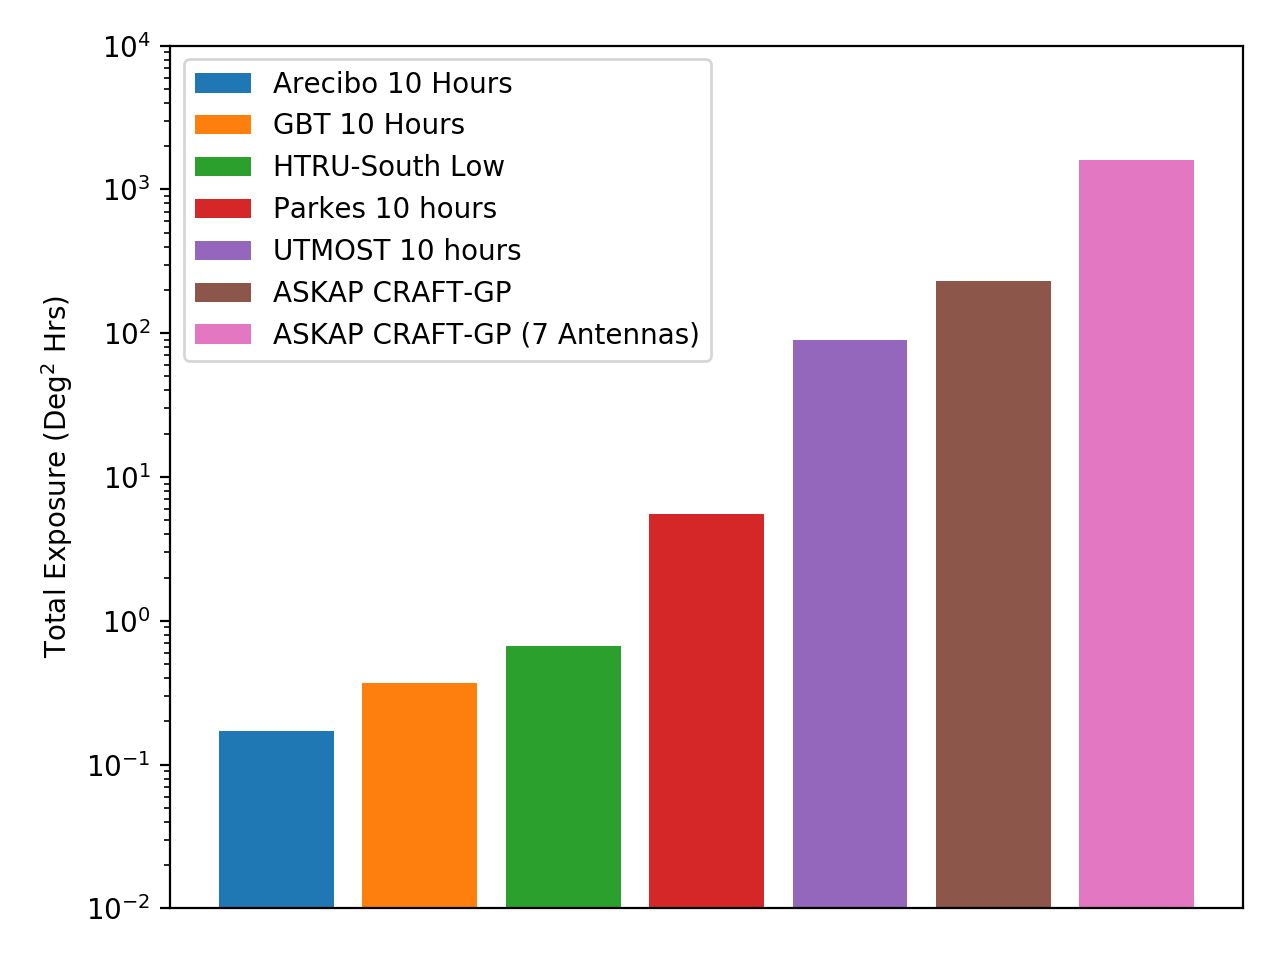

0.17138587840000002


In [12]:
plt.figure(5)
plt.ylabel("Total Exposure (Deg$^2$ Hrs)")
plt.yscale("log")
plt.ylim(0.01,1e4)
plt.xticks([])
#plt.bar(1,parkes*pmbs_time,label='PMPS')
plt.bar(1,palfa*askap_t/3600,label='Arecibo 10 Hours')
plt.bar(2,gbt*askap_t/3600,label='GBT 10 Hours')
print(palfa*askap_t/3600)
plt.bar(3,parkes*htru_time/3600,label='HTRU-South Low')
plt.bar(4,parkes*askap_t/3600,label='Parkes 10 hours')
plt.bar(5,utmost*askap_t/3600,label='UTMOST 10 hours')
plt.bar(6,askap*askap_t/3600,label='ASKAP CRAFT-GP ')
plt.bar(7,askap*7*askap_t/3600,label='ASKAP CRAFT-GP (7 Antennas)')

plt.legend()
plt.tight_layout()
plt.savefig("param_space_log.pdf")
plt.show()

In [ ]:
###### frb rate calc

def poisson_func(lamda,k):
    pdf=(lamda**k)*np.exp(-lamda)/np.math.factorial(k)
    return pdf

In [ ]:
34692.45

In [24]:
len(oc)

40